In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys
sys.path.append('D:\\Compute Science\\Machine Learning\\论文\\项目\\FairSPL\\venv_torch')
sys.path.append('D:\\Compute Science\\Machine Learning\\论文\\项目\\FairSPL\\venv_torch\\lib\\site-packages')

In [2]:
import json
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataset import fetch_data
from models.AdversarialDebiasing import AdversarialDebiasing
from eval import Evaluator
from utils import get_curriculum_stages
# from tmp.AdversarialDebiasing_copied2_before_lr import AdversarialDebiasing

In [3]:
data = fetch_data("compas")
print("data.x_train.shape: ", data.x_train.shape)
print("data.x_test.shape: ", data.x_test.shape)
origin_evaluator, train_evaluator, test_evaluator = Evaluator(data.s_train, "origin"), Evaluator(data.s_train,
                                                                                                 "train"), Evaluator(
    data.s_test, "test")
if data.s_val is not None:
    val_evaluator = Evaluator(data.s_val, "val")

n_features, n_classes, n_groups = data.x_train.shape[1], len(np.unique(data.y_train)), len(np.unique(data.s_train))
if n_classes == 2:
    n_classes = 1
if n_groups == 2:
    n_groups = 1

print("========== before train ==========")
origin_res = origin_evaluator(data.y_train, no_train=True)

Dataset statistic - #total: 26365; #train: 14128; #val.: 3532; #test: 8705; #dim.: 401

data.x_train.shape:  (14128, 401)
data.x_test.shape:  (8705, 401)
========== before train ==========
========== Results on origin ==========
Grp. 0 - #instance: 8452; #pos : 4060
Grp. 1 - #instance: 5676; #pos : 3443
Demographic parity: 0.126229; Equal opportunity: 0.000000


## Traditional without debias

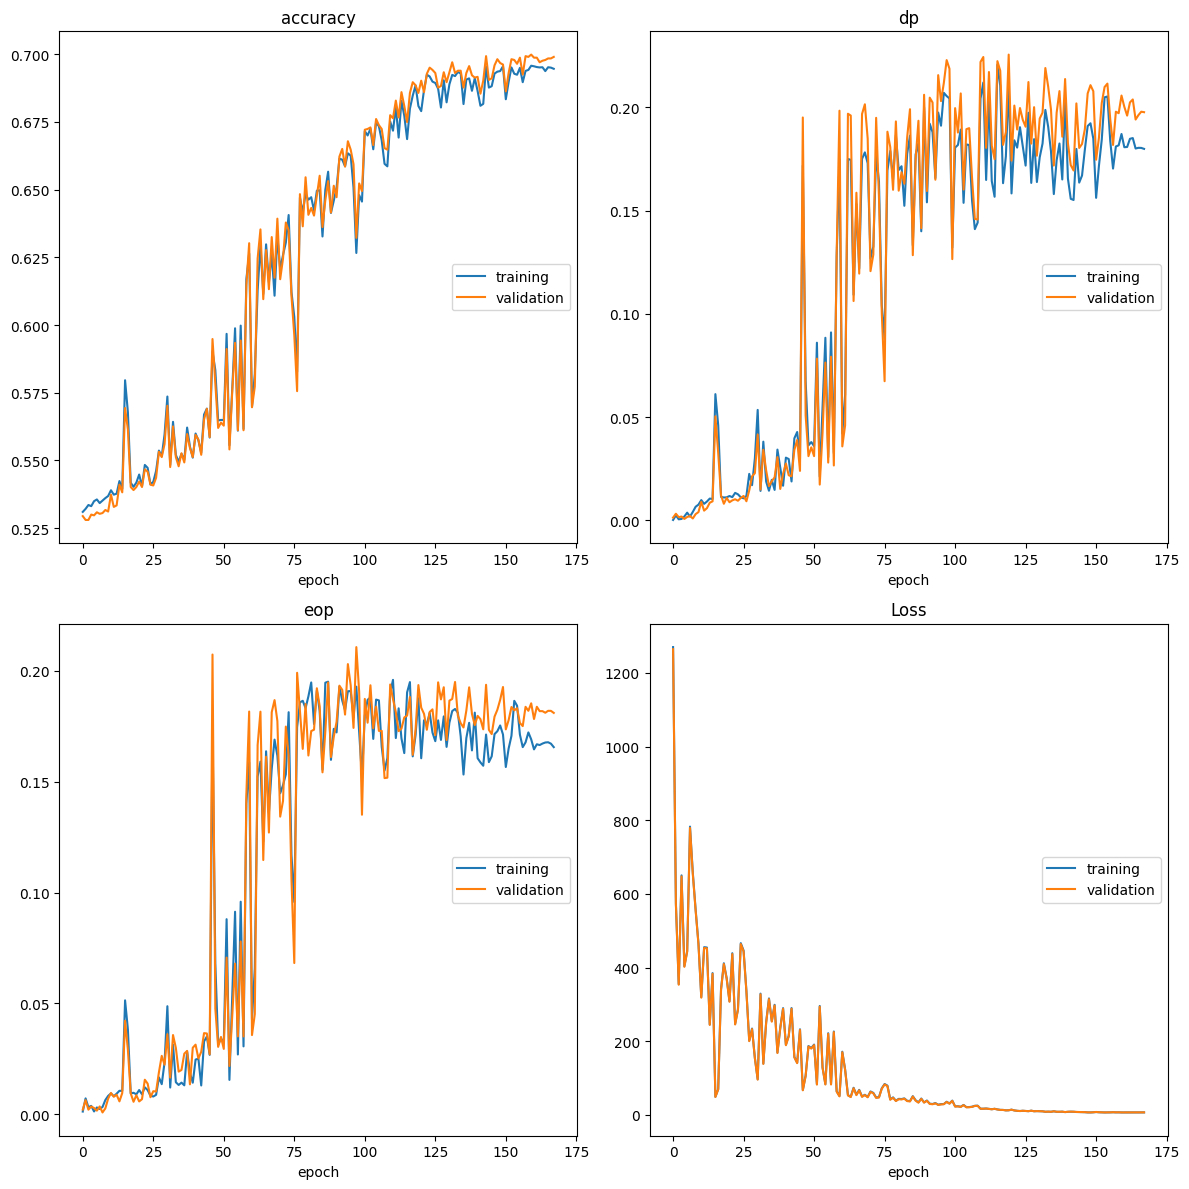

Classifier Training Epoch: 100%|██████████| 300/300 [08:04<00:00,  1.61s/it, acc=0.589, loss=20.7]

accuracy
	training         	 (min:    0.531, max:    0.696, cur:    0.695)
	validation       	 (min:    0.528, max:    0.700, cur:    0.699)
dp
	training         	 (min:    0.000, max:    0.221, cur:    0.180)
	validation       	 (min:    0.001, max:    0.226, cur:    0.198)
eop
	training         	 (min:    0.001, max:    0.196, cur:    0.166)
	validation       	 (min:    0.001, max:    0.211, cur:    0.181)
Loss
	training         	 (min:    6.666, max: 1270.119, cur:    6.794)
	validation       	 (min:    6.745, max: 1264.474, cur:    6.902)
484


In [17]:
start = datetime.datetime.now()
clf_no_debias = AdversarialDebiasing(n_features, n_classes, n_groups, num_epochs=300, batch_size=512,
                     classifier_num_hidden_units=data.x_train.shape[1], random_state=42, debias=False, starter_learning_rate=0.0008)

loss_list_no_debias, val_list_no_debias, train_info_no_debias, val_info_no_debias = clf_no_debias.fit(data.x_train, data.y_train, data.s_train, 
                                                    early_stopping=False, patience=10, validation_set=[data.x_val, data.y_val, data.s_val])
end = datetime.datetime.now()
print((end - start).seconds)

In [15]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_no_debias.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_no_debias.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 8452; #pos. pred: 4495; Acc.: 0.690133
Grp. 1 - #instance: 5676; #pos. pred: 4040; Acc.: 0.701374
Overall acc.: 0.694649; Demographic parity: 0.179942; Equal opportunity: 0.165533
========== Results on test ==========
Grp. 0 - #instance: 5296; #pos. pred: 2669; Acc.: 0.684856
Grp. 1 - #instance: 3409; #pos. pred: 2326; Acc.: 0.688178
Overall acc.: 0.686157; Demographic parity: 0.178346; Equal opportunity: 0.163297


In [17]:
clf_no_debias.stopped_batch_ids

[8400]

In [16]:
order_and_save_idx = True
if order_and_save_idx:
    clf_no_debias.sorted_loss(data.x_train, data.y_train, data.s_train,
                    idx_path='data/compas/no_debias_sorted_idx_%d.json' % data.num_val)
#     clf.sorted_loss(data.x_train, data.y_train, data.s_train,
#                     idx_path='data/adult/sorted_idx_%d.json' % data.num_val)

========== sort and save ==========
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.9883e+01, 5.8651e-01,
        1.1921e-07])


## CL without debias

In [18]:
N = 3
stages = get_curriculum_stages(data.y_train, data.s_train, 'data/compas/no_debias_sorted_idx_%d.json' % data.num_val, N=N)
# 从难到易
# stages.reverse()
# 并集
# new_stages = []
# for i in range(len(stages) - 1, 0, -1):
#     new_stages.append(np.concatenate([stages[i], stages[i - 1]]))

# new_stages.append(stages[0])
# new_stages.reverse()
# base_epoch = 500
# epoch_list = [int(base_epoch / i) for i in range(1,N+1)]
# epoch_list.reverse()

new_stages = [stages[0]]
for i in range(1, len(stages)):
    new_stages.append(np.concatenate([stages[i], new_stages[-1]]))

g:0, y:0 ==> size:1464
g:0, y:1 ==> size:1353
g:1, y:0 ==> size:744
g:1, y:1 ==> size:1147
g:0, y:0 ==> size:1464
g:0, y:1 ==> size:1353
g:1, y:0 ==> size:744
g:1, y:1 ==> size:1147
g:0, y:0 ==> size:1464
g:0, y:1 ==> size:1353
g:1, y:0 ==> size:744
g:1, y:1 ==> size:1147


In [19]:
for stage in new_stages:
    print(stage.shape)

(4708,)
(9416,)
(14124,)


In [22]:
epoch_list = [100, 100] + [100]
lr_list = [0.0008, 0.001, 0.001]
epoch_list

[100, 100, 100]

In [23]:
# CL test
clf_ncl = AdversarialDebiasing(n_features, n_classes, n_groups, adversary_loss_weight=0.1,
                              scope_name='CL_without_Adversary_classifier', num_epochs=300, starter_learning_rate=0.0008,
                              batch_size=512, classifier_num_hidden_units=data.x_train.shape[1], random_state=42, debias=False)
loss_lists, val_lists, train_infos, val_infos = [], [], [], []
start = datetime.datetime.now()
for num_epoch, stage, lr in zip(epoch_list, new_stages, lr_list):
    # TODO: try set1 U set2
    print(len(stage))
    clf_ncl.num_epochs = num_epoch
    clf_ncl.starter_learning_rate = lr
    x_train = data.x_train[stage, :]
    y_train = data.y_train[stage]
    s_train = data.s_train[stage]
    loss_list, val_list, train_info, val_info = \
        clf_ncl.fit(x_train, y_train, s_train, early_stopping=False, patience=6, validation_set=[data.x_val, data.y_val, data.s_val])
    loss_lists.append(loss_list)
    val_lists.append(val_list)
    train_infos.append(train_info)
    val_infos.append(val_info)

end = datetime.datetime.now()
print((end - start).seconds)

Classifier Training Epoch:  10%|█         | 10/100 [00:13<02:05,  1.40s/it, acc=0.572, loss=947]


KeyboardInterrupt: 

In [58]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_ncl.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_ncl.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 2588; #pos. pred: 1281; Acc.: 0.658810
Grp. 1 - #instance: 1687; #pos. pred: 1216; Acc.: 0.671606
Overall acc.: 0.663860; Demographic parity: 0.225829; Equal opportunity: 0.220203
========== Results on test ==========
Grp. 0 - #instance: 312; #pos. pred: 154; Acc.: 0.705128
Grp. 1 - #instance: 216; #pos. pred: 151; Acc.: 0.638889
Overall acc.: 0.678030; Demographic parity: 0.205484; Equal opportunity: 0.274671


In [57]:
print(clf_ncl.stopped_batch_ids)
sum(clf_ncl.stopped_batch_ids)

[180, 460, 1360]


2000

In [7]:
# from tqdm import tqdm_notebook as tqdm

In [12]:
def get_df(infos, loss_lists):
    df_list = []
    N = len(infos)
    for i in range(N):
        tmp = pd.DataFrame(infos[i])
        tmp['loss'] = loss_lists[i]
        df_list.append(tmp)
    res = pd.concat(df_list, axis=0)
    res = res.reset_index()
    return res

In [21]:
df = get_df(train_infos, loss_lists)
df.describe()

,index,overall_acc,dp,eop,average_odds_difference,grp_0_acc,grp_1_acc,loss
count,138.00000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,26.23913,0.910932,0.193008,0.050773,0.049385,0.955351,0.889568,1.210390
std,19.15917,0.064061,0.041593,0.059196,0.047976,0.029585,0.081271,1.006708
min,0.00000,0.811701,0.114901,-0.027534,0.006761,0.857092,0.774120,0.168900
25%,11.00000,0.854188,0.171113,0.016915,0.018525,0.930378,0.816164,0.383036
50%,22.50000,0.866463,0.200151,0.032071,0.028898,0.937175,0.832310,1.257268
75%,36.75000,0.979212,0.207032,0.076109,0.065432,0.988209,0.974203,1.817666
max,71.00000,0.991593,0.318528,0.316560,0.297403,0.992730,0.991131,7.574467


<AxesSubplot:>

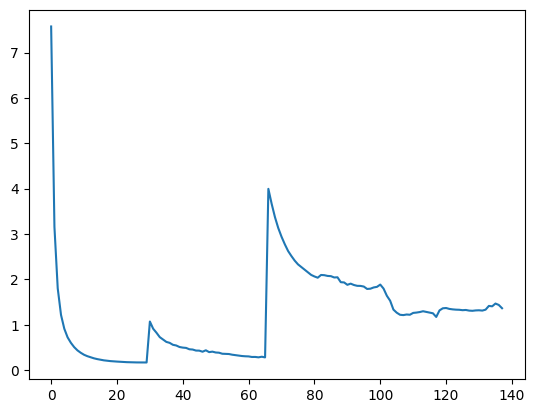

In [22]:
df['loss'][:].plot()

In [17]:
val_df = get_df(val_infos, val_lists)

<AxesSubplot:>

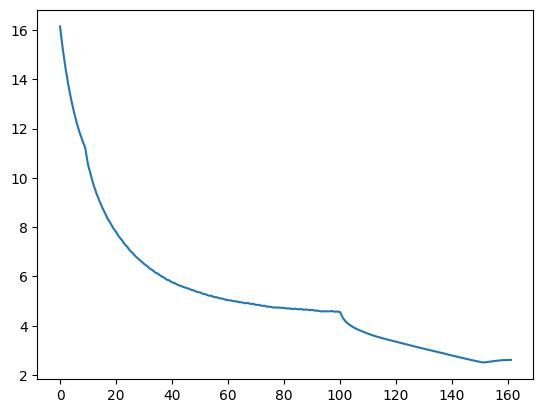

In [18]:
val_df['loss'][:].plot()

## 随机打乱

In [30]:
# 随机打乱顺序试一下
import random
idx = [i for i in range(len(data.x_train))]
random.shuffle(idx)

In [31]:
N = 3
n = int(len(idx) / N)
stages = [np.array(idx[i:i + n]) for i in range(0, len(idx), n)]

In [32]:
N = 3
# stages = get_curriculum_stages(data.y_train, data.s_train, 'data/adult/no_debias_sorted_idx_%d.json' % data.num_val, N=N)
# 从难到易
# stages.reverse()
# 并集
# new_stages = []
# for i in range(len(stages) - 1, 0, -1):
#     new_stages.append(np.concatenate([stages[i], stages[i - 1]]))

# new_stages.append(stages[0])
# new_stages.reverse()
# base_epoch = 500
# epoch_list = [int(base_epoch / i) for i in range(1,N+1)]
# epoch_list.reverse()

new_stages = [stages[0]]
for i in range(1, len(stages)):
    new_stages.append(np.concatenate([stages[i], new_stages[-1]]))
    
for stage in new_stages:
    print(stage.shape)

(8683,)
(17366,)
(26049,)


In [33]:
epoch_list = [240, 240] + [300]
lr_list = [0.01, 0.001, 0.001]
epoch_list

[240, 240, 300]

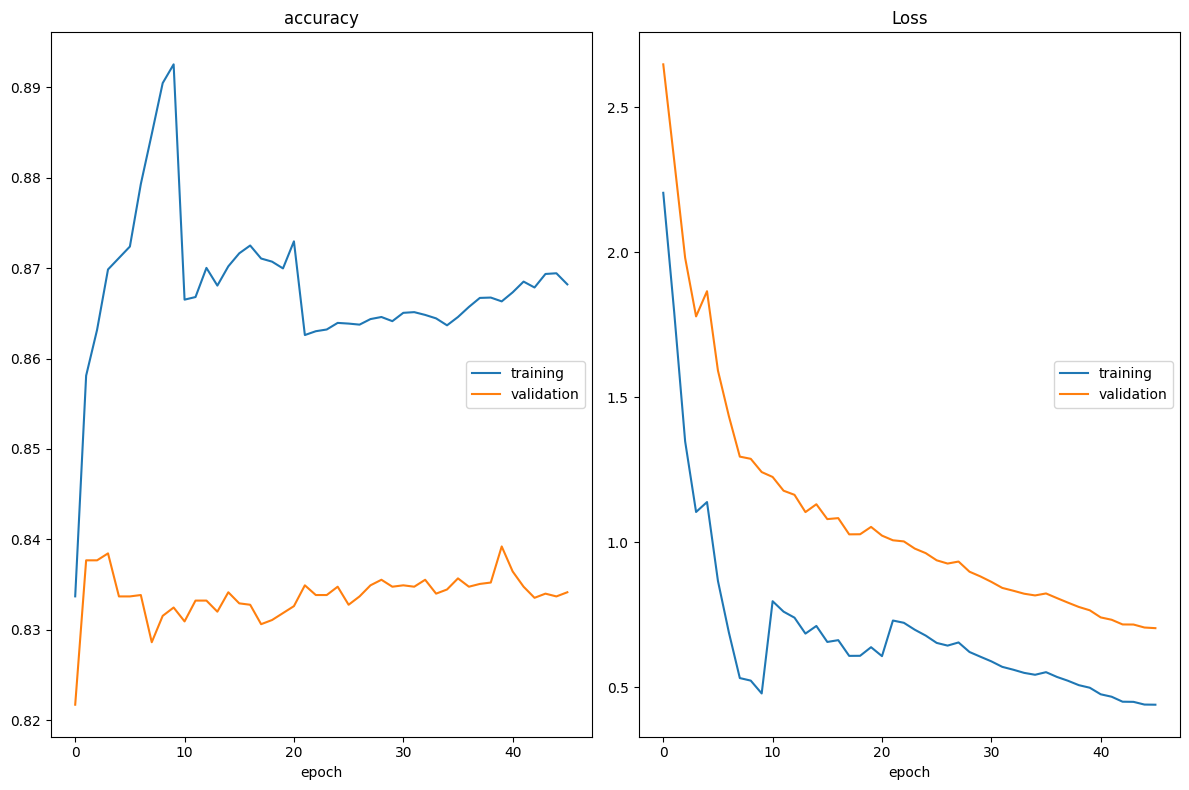

Classifier Training Epoch:   8%|▊         | 24/300 [01:29<17:08,  3.73s/it, acc=0.826, loss=0.916]

accuracy
	training         	 (min:    0.834, max:    0.893, cur:    0.868)
	validation       	 (min:    0.822, max:    0.839, cur:    0.834)
Loss
	training         	 (min:    0.439, max:    2.205, cur:    0.439)
	validation       	 (min:    0.703, max:    2.648, cur:    0.703)
EarlyStopping counter: 6 out of 6
144


In [34]:
# CL test
clf_cl = AdversarialDebiasing(n_features, n_classes, n_groups, adversary_loss_weight=0.1,
                              scope_name='CL_Adversary_classifier', num_epochs=500, starter_learning_rate=0.001,
                              batch_size=512, classifier_num_hidden_units=512, random_state=42, debias=False)
loss_lists, val_lists, train_infos, val_infos = [], [], [], []
start = datetime.datetime.now()
for num_epoch, stage, lr in zip(epoch_list, new_stages, lr_list):
    # TODO: try set1 U set2
    print(len(stage))
    clf_cl.num_epochs = num_epoch
    clf_cl.starter_learning_rate = lr
    x_train = data.x_train[stage, :]
    y_train = data.y_train[stage]
    s_train = data.s_train[stage]
    loss_list, val_list, train_info, val_info = \
        clf_cl.fit(x_train, y_train, s_train, early_stopping=True, patience=6, validation_set=[data.x_val, data.y_val, data.s_val])
    loss_lists.append(loss_list)
    val_lists.append(val_list)
    train_infos.append(train_info)
    val_infos.append(val_info)

end = datetime.datetime.now()
print((end - start).seconds)

In [35]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_cl.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_cl.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 8460; #pos. pred: 742; Acc.: 0.940189
Grp. 1 - #instance: 17589; #pos. pred: 4539; Acc.: 0.833589
Overall acc.: 0.868210; Demographic parity: 0.170352; Equal opportunity: 0.022962; Average odds difference: 0.024048
========== Results on test ==========
Grp. 0 - #instance: 4147; #pos. pred: 395; Acc.: 0.911743
Grp. 1 - #instance: 8514; #pos. pred: 2147; Acc.: 0.798215
Overall acc.: 0.835400; Demographic parity: 0.156923; Equal opportunity: 0.050997; Average odds difference: 0.059903


In [36]:
print(clf_cl.stopped_batch_ids)
sum(clf_cl.stopped_batch_ids)

[500, 550, 1250]


2300

## Traditional with debias

In [4]:
data.x_train.shape

(14128, 401)

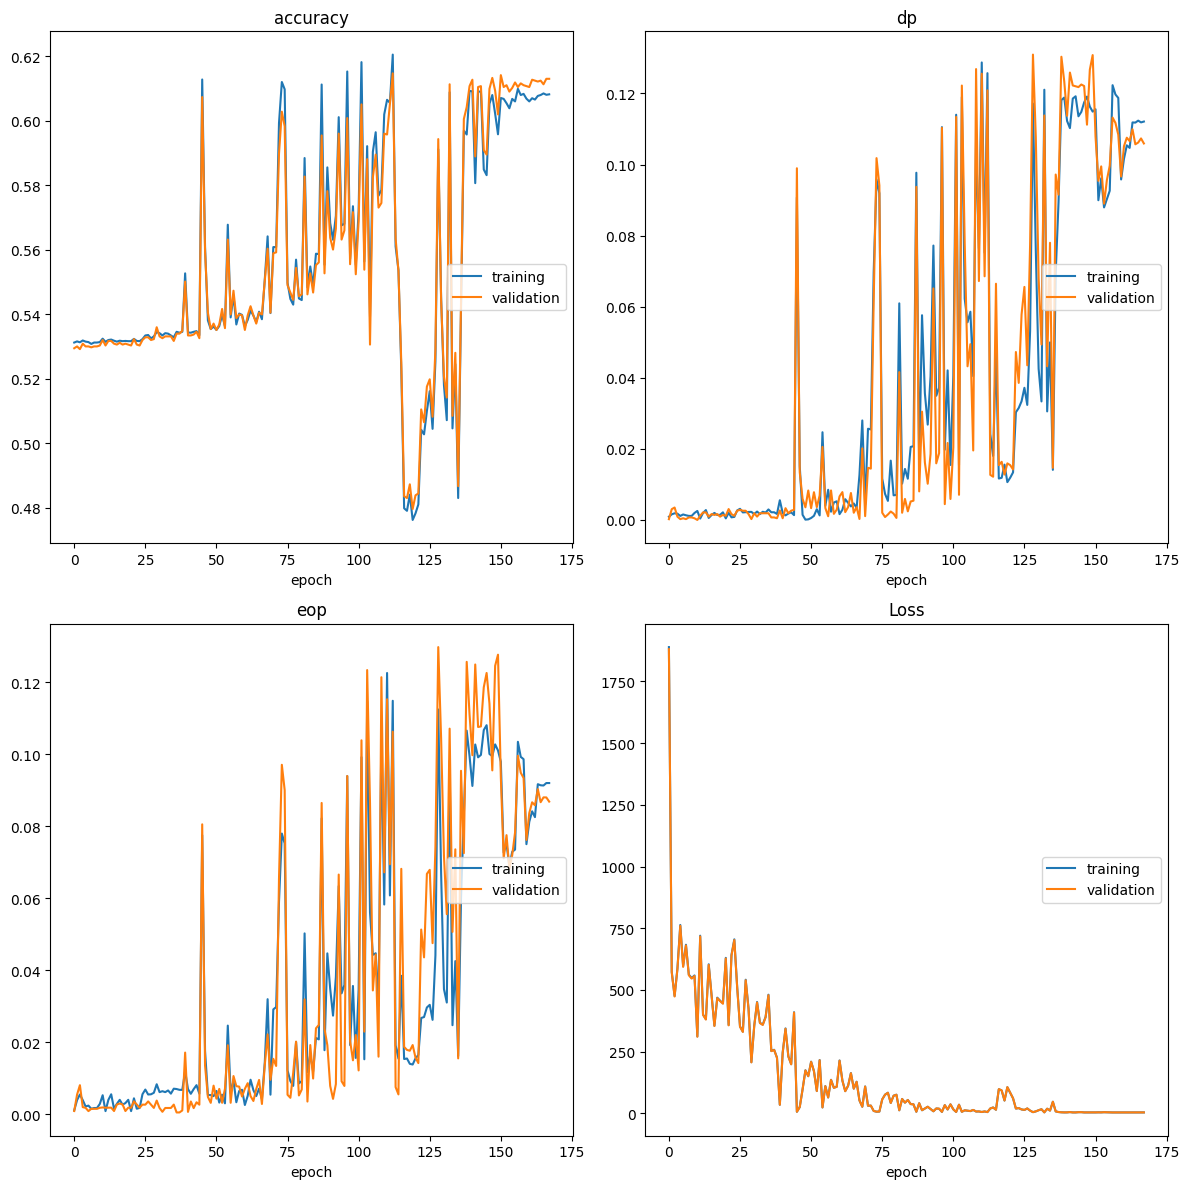

Adversarial Debiasing Training Epoch: 100%|██████████| 300/300 [11:34<00:00,  2.32s/it, accADV=0.599, accCLF=0.47, lossADV=0.669, lossCLF=450]

accuracy
	training         	 (min:    0.476, max:    0.620, cur:    0.608)
	validation       	 (min:    0.480, max:    0.615, cur:    0.613)
dp
	training         	 (min:    0.000, max:    0.129, cur:    0.112)
	validation       	 (min:    0.000, max:    0.131, cur:    0.106)
eop
	training         	 (min:    0.001, max:    0.123, cur:    0.092)
	validation       	 (min:    0.000, max:    0.130, cur:    0.087)
Loss
	training         	 (min:    3.682, max: 1889.341, cur:    3.795)
	validation       	 (min:    3.725, max: 1880.956, cur:    3.856)
694


In [19]:
start = datetime.datetime.now()
clf = AdversarialDebiasing(n_features, n_classes, n_groups, scope_name="Adv", adversary_loss_weight=0.00001, num_epochs=300, batch_size=512, starter_learning_rate=0.0008,
                     classifier_num_hidden_units=data.x_train.shape[1], random_state=42, debias=True)

loss_list_no_debias, val_list_no_debias, train_info_no_debias, val_info_no_debias = clf.fit(data.x_train, data.y_train, data.s_train, 
                                                    early_stopping=False, validation_set=[data.x_val, data.y_val, data.s_val])
end = datetime.datetime.now()
print((end - start).seconds)

In [20]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 8452; #pos. pred: 5539; Acc.: 0.583176
Grp. 1 - #instance: 5676; #pos. pred: 4356; Acc.: 0.645349
Overall acc.: 0.608154; Demographic parity: 0.112094; Equal opportunity: 0.091980
========== Results on test ==========
Grp. 0 - #instance: 5296; #pos. pred: 3898; Acc.: 0.569109
Grp. 1 - #instance: 3409; #pos. pred: 2776; Acc.: 0.630097
Overall acc.: 0.592993; Demographic parity: 0.078288; Equal opportunity: 0.078814


In [24]:

clf.stopped_batch_ids

NameError: name 'clf' is not defined

In [ ]:
clf.stopped_batch_ids[0]

In [34]:
# fpath = clf.early_stopping.root_path + clf.scope_name + str(clf.stopped_batch_ids[0] - (clf.patience+2) * 50) + '.pt'
# print(fpath)
# cp = torch.load(fpath)
# clf.clf_model.load_state_dict(cp['model_clf_model_state_dict'])
# clf.adv_model.load_state_dict(cp['model_adv_model_state_dict'])

checkpoint/Adv6300.pt


<All keys matched successfully>

In [10]:
df = pd.DataFrame(train_info_no_debias)
df['loss'] = loss_list_no_debias
df.describe()

,overall_acc,dp,eop,average_odds_difference,grp_0_acc,grp_1_acc,loss
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,0.816426,0.058746,-0.166812,0.337117,0.905791,0.773443,0.671489
std,0.037453,0.143636,0.301075,0.244028,0.032582,0.044234,0.513081
min,0.680333,-0.261777,-0.732410,0.002070,0.688416,0.635170,0.393497
25%,0.781316,-0.051330,-0.363657,0.218444,0.895567,0.737649,0.433261
50%,0.829053,0.033787,-0.225677,0.311476,0.916312,0.787481,0.525002
75%,0.845484,0.183957,0.042202,0.428259,0.923463,0.808147,0.629099
max,0.866482,0.471850,0.641438,1.555755,0.938180,0.832168,5.751064


<AxesSubplot:>

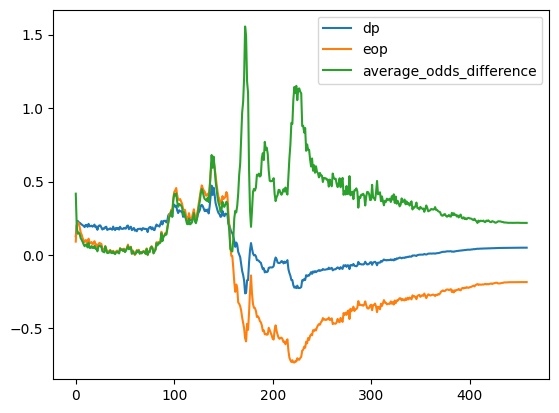

In [11]:
df['abs_dp'] = abs(df['dp'])
df['abs_eop'] = abs(df['eop'])
df['abs_aod'] = abs(df['average_odds_difference'])
df[['dp', 'eop', 'average_odds_difference']].iloc[:, :].plot()

In [13]:
order_and_save_idx = False
if order_and_save_idx:
    clf.sorted_loss(data.x_train, data.y_train, data.s_train, idx_path='data/adult/sorted_idx_%d.json' % data.num_val)

========== sort and save ==========
tensor([0.1009, 0.0820, 0.0444,  ..., 0.0373, 0.7934, 0.9082])


## CL with debias

In [13]:
N = 3
stages = get_curriculum_stages(data.y_train, data.s_train, 'data/adult/sorted_idx_%d.json' % data.num_val, N=N)
# 从难到易
# stages.reverse()
# 并集
# new_stages = []
# for i in range(len(stages) - 1, 0, -1):
#     new_stages.append(np.concatenate([stages[i], stages[i - 1]]))

# new_stages.append(stages[0])
# new_stages.reverse()
# base_epoch = 500
# epoch_list = [int(base_epoch / i) for i in range(1,N+1)]
# epoch_list.reverse()

new_stages = [stages[0]]
for i in range(1, len(stages)):
    new_stages.append(np.concatenate([stages[i], new_stages[-1]]))

g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832
g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832
g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832


In [14]:
for stage in new_stages:
    print(stage.shape)

(8683,)
(17366,)
(26049,)


In [15]:
epoch_list = [20, 20] + [235]
lr_list = [1e-3, 1e-2, 1e-3]
epoch_list

[20, 20, 235]

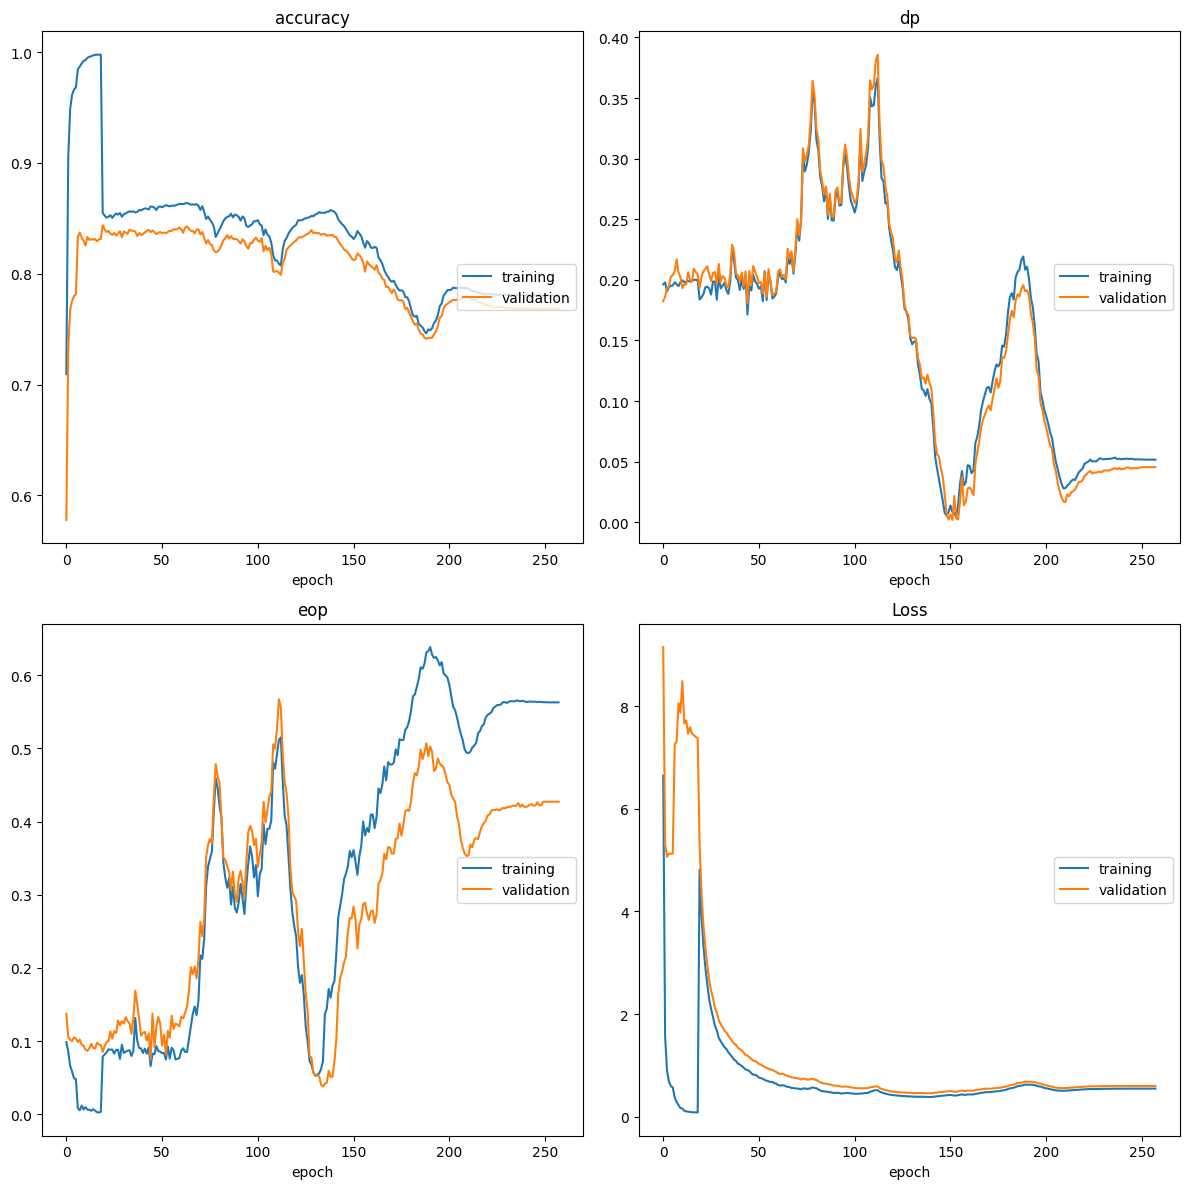

Adversarial Debiasing Training Epoch: 100%|█████████▉| 234/235 [11:01<00:03,  3.08s/it, accADV=0.688, accCLF=0.777, lossADV=0.621, lossCLF=0.528]

accuracy
	training         	 (min:    0.709, max:    0.998, cur:    0.781)
	validation       	 (min:    0.578, max:    0.844, cur:    0.768)
dp
	training         	 (min:    0.005, max:    0.366, cur:    0.052)
	validation       	 (min:    0.002, max:    0.386, cur:    0.046)
eop
	training         	 (min:    0.003, max:    0.638, cur:    0.563)
	validation       	 (min:    0.038, max:    0.567, cur:    0.427)
Loss
	training         	 (min:    0.080, max:    6.652, cur:    0.545)
	validation       	 (min:    0.455, max:    9.157, cur:    0.598)


Adversarial Debiasing Training Epoch: 100%|██████████| 235/235 [11:01<00:00,  2.82s/it, accADV=0.704, accCLF=0.766, lossADV=0.611, lossCLF=0.556]

708


In [16]:
# CL test
clf_cl = AdversarialDebiasing(n_features, n_classes, n_groups, adversary_loss_weight=0.1,
                              scope_name='CL_Adversary_classifier', num_epochs=500, starter_learning_rate=1e-5,
                              batch_size=512, classifier_num_hidden_units=512, random_state=50, debias=True)
loss_lists, val_lists, train_infos, val_infos = [], [], [], []
start = datetime.datetime.now()
for num_epoch, stage, lr in zip(epoch_list, new_stages, lr_list):
    # TODO: try set1 U set2
    print(len(stage))
    clf_cl.num_epochs = num_epoch
    clf_cl.starter_learning_rate = lr
    x_train = data.x_train[stage, :]
    y_train = data.y_train[stage]
    s_train = data.s_train[stage]
    loss_list, val_list, train_info, val_info = \
        clf_cl.fit(x_train, y_train, s_train, early_stopping=False, patience=6, validation_set=[data.x_val, data.y_val, data.s_val])
    loss_lists.append(loss_list)
    val_lists.append(val_list)
    train_infos.append(train_info)
    val_infos.append(val_info)

end = datetime.datetime.now()
print((end - start).seconds)

In [17]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_cl.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_cl.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 8460; #pos. pred: 1074; Acc.: 0.923168
Grp. 1 - #instance: 17589; #pos. pred: 1323; Acc.: 0.711922
Overall acc.: 0.780529; Demographic parity: 0.051733; Equal opportunity: 0.562834
========== Results on test ==========
Grp. 0 - #instance: 4147; #pos. pred: 517; Acc.: 0.900169
Grp. 1 - #instance: 8514; #pos. pred: 648; Acc.: 0.704134
Overall acc.: 0.768344; Demographic parity: 0.048558; Equal opportunity: 0.464989


In [12]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_cl.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_cl.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

========== after train(without debiasing) ==========
========== Results on train ==========
Grp. 0 - #instance: 8460; #pos. pred: 1074; Acc.: 0.923168
Grp. 1 - #instance: 17589; #pos. pred: 1323; Acc.: 0.711922
Overall acc.: 0.780529; Demographic parity: -0.051733; Equal opportunity: -0.562834; Average odds difference: 0.442533
========== Results on test ==========
Grp. 0 - #instance: 4147; #pos. pred: 517; Acc.: 0.900169
Grp. 1 - #instance: 8514; #pos. pred: 648; Acc.: 0.704134
Overall acc.: 0.768344; Demographic parity: -0.048558; Equal opportunity: -0.464989; Average odds difference: 0.423177


In [13]:
print(clf_cl.stopped_batch_ids)
sum(clf_cl.stopped_batch_ids)

[340, 680, 11985]


13005

In [14]:
def get_df(infos, loss_lists):
    df_list = []
    N = len(infos)
    for i in range(N):
        tmp = pd.DataFrame(infos[i])
        tmp['loss'] = loss_lists[i]
        df_list.append(tmp)
    res = pd.concat(df_list, axis=0)
    res = res.reset_index()
    return res

In [17]:
len(train_infos)

3

In [20]:
df = get_df(train_infos, loss_lists)
df.describe()

,index,overall_acc,dp,eop,average_odds_difference,grp_0_acc,grp_1_acc,loss
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000
mean,110.596899,0.831624,0.089315,-0.149489,0.362950,0.912266,0.792837,0.653637
std,72.933317,0.054433,0.158535,0.359155,0.294602,0.044094,0.067279,0.635456
min,0.000000,0.709432,-0.219268,-0.638313,0.002101,0.726950,0.701006,0.080263
25%,45.250000,0.782688,-0.051847,-0.536210,0.073161,0.913387,0.725311,0.448194
50%,109.500000,0.840032,0.159803,-0.007747,0.357011,0.923168,0.806356,0.530634
75%,173.750000,0.855234,0.204404,0.090032,0.459000,0.930703,0.819461,0.576539
max,238.000000,0.997754,0.366380,0.514938,1.170131,0.999645,0.996930,6.652437


<AxesSubplot:>

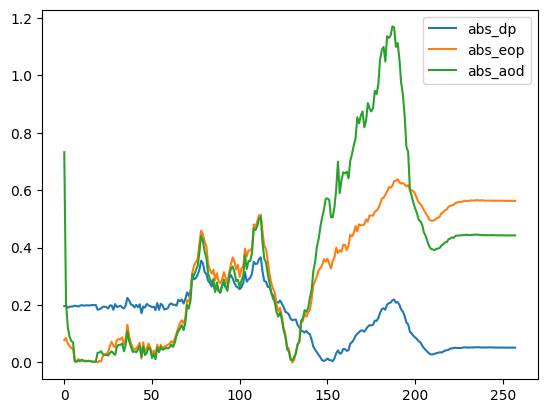

In [21]:
df['abs_dp'] = abs(df['dp'])
df['abs_eop'] = abs(df['eop'])
df['abs_aod'] = abs(df['average_odds_difference'])

df[['abs_dp', 'abs_eop', 'abs_aod']].plot()

## CL with hard first

In [11]:
# idx_path = 'data/adult/sorted_idx_%d.json' % data.num_val
# with open(idx_path) as f:
#     idx = json.load(f)
    
# idx.reverse()
# idx_path = 'data/adult/reverse_sorted_idx_%d.json' % data.num_val
# with open(idx_path, 'w') as f:
#     json.dump(idx, f)

In [20]:
N = 3
stages = get_curriculum_stages(data.y_train, data.s_train, 'data/adult/reverse_sorted_idx_%d.json' % data.num_val, N=N)

new_stages = [stages[0]]
for i in range(1, len(stages)):
    new_stages.append(np.concatenate([stages[i], new_stages[-1]]))

g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832
g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832
g:0, y:0 ==> size:2502
g:0, y:1 ==> size:318
g:1, y:0 ==> size:4031
g:1, y:1 ==> size:1832


In [27]:
epoch_list = [50, 60] + [210]
epoch_list.reverse()
lr_list = [1e-4, 1e-3, 1e-3]
epoch_list

[235, 50, 50]

In [28]:
for stage in new_stages:
    print(stage.shape)

(8683,)
(17366,)
(26049,)


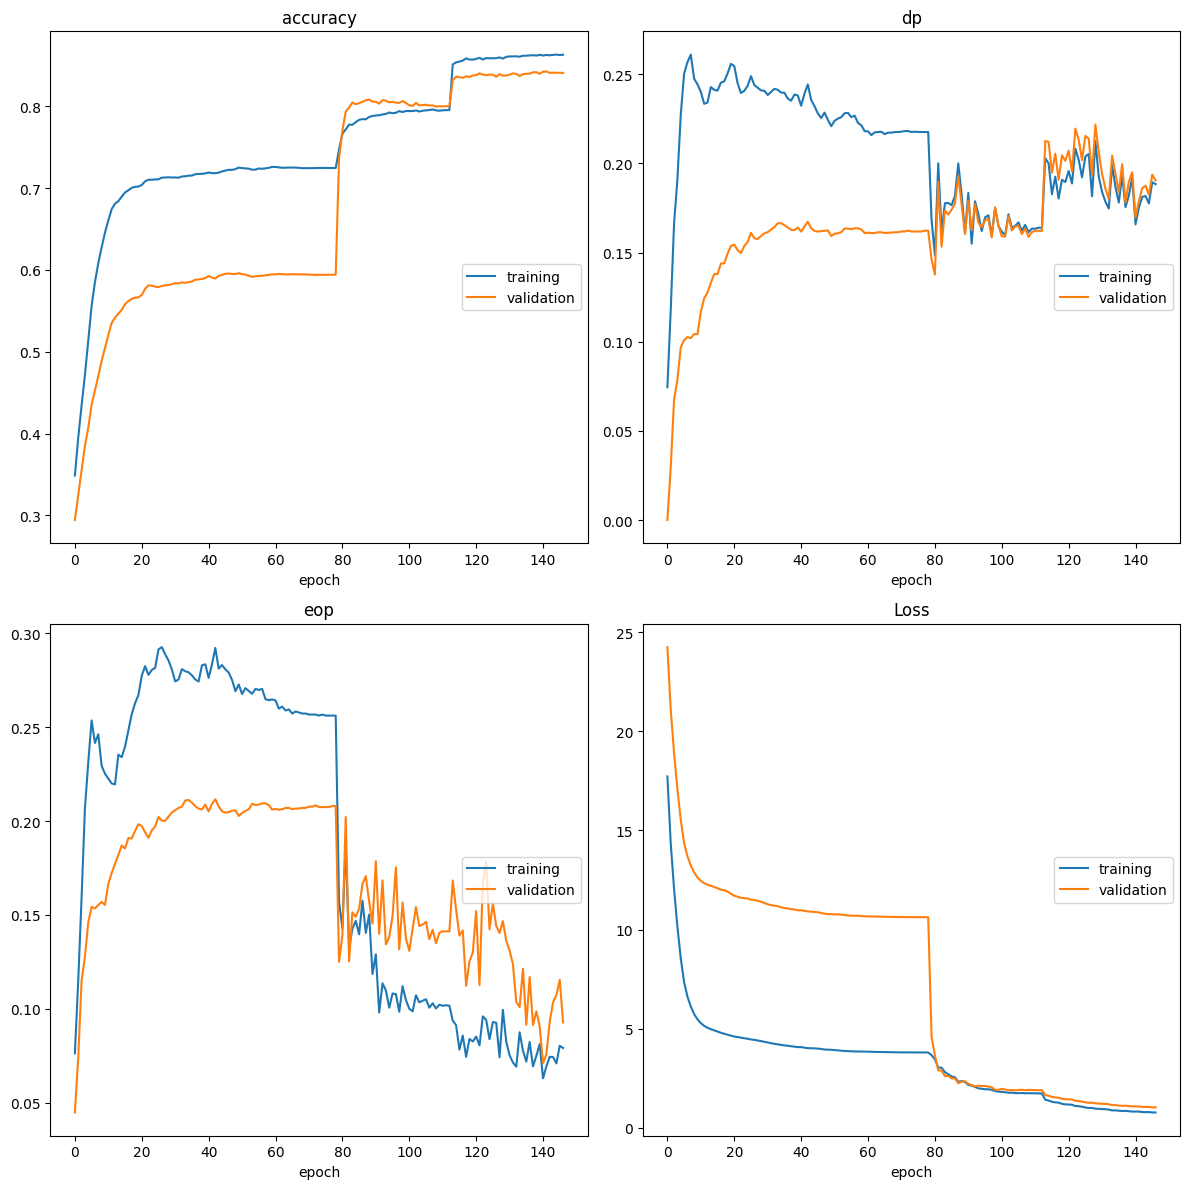

Adversarial Debiasing Training Epoch:  66%|██████▌   | 33/50 [01:42<00:49,  2.90s/it, accADV=0.676, accCLF=0.803, lossADV=0.593, lossCLF=1.38]

accuracy
	training         	 (min:    0.349, max:    0.863, cur:    0.863)
	validation       	 (min:    0.295, max:    0.843, cur:    0.841)
dp
	training         	 (min:    0.075, max:    0.261, cur:    0.188)
	validation       	 (min:    0.000, max:    0.222, cur:    0.190)
eop
	training         	 (min:    0.063, max:    0.293, cur:    0.079)
	validation       	 (min:    0.045, max:    0.212, cur:    0.093)
Loss
	training         	 (min:    0.772, max:   17.727, cur:    0.773)
	validation       	 (min:    1.028, max:   24.253, cur:    1.032)


Adversarial Debiasing Training Epoch:  68%|██████▊   | 34/50 [01:43<00:46,  2.90s/it, accADV=0.66, accCLF=0.838, lossADV=0.616, lossCLF=1.2]   

In [ ]:
# CL test
clf_cl = AdversarialDebiasing(n_features, n_classes, n_groups, adversary_loss_weight=0.1,
                              scope_name='CL_Adversary_classifier', num_epochs=500, starter_learning_rate=1e-5,
                              batch_size=512, classifier_num_hidden_units=512, random_state=50, debias=True)
loss_lists, val_lists, train_infos, val_infos = [], [], [], []
start = datetime.datetime.now()
for num_epoch, stage, lr in zip(epoch_list, new_stages, lr_list):
    # TODO: try set1 U set2
    print(len(stage))
    clf_cl.num_epochs = num_epoch
    clf_cl.starter_learning_rate = lr
    x_train = data.x_train[stage, :]
    y_train = data.y_train[stage]
    s_train = data.s_train[stage]
    loss_list, val_list, train_info, val_info = \
        clf_cl.fit(x_train, y_train, s_train, early_stopping=False, patience=6, validation_set=[data.x_val, data.y_val, data.s_val])
    loss_lists.append(loss_list)
    val_lists.append(val_list)
    train_infos.append(train_info)
    val_infos.append(val_info)

end = datetime.datetime.now()
print((end - start).seconds)

In [ ]:
print("========== after train(without debiasing) ==========")
pred_label_train = clf_cl.predict(data.x_train)
train_res = train_evaluator(data.y_train, pred_label_train, no_train=False)

pred_label_test = clf_cl.predict(data.x_test)
test_res = test_evaluator(data.y_test, pred_label_test, no_train=False)

In [ ]:
print(clf_cl.stopped_batch_ids)
sum(clf_cl.stopped_batch_ids)